In [2]:
# uncomment if you're don't have wget
!pip install wget


  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=9382d06ba24121ce4ccf3c31644b7701ecdcdc513cfbcf6ffb16adbfeb485ccb
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wget
import torch
import os
%matplotlib inline

In [4]:
#константы
LINK = 'https://api.blockchain.info/charts/market-price?format=csv'
LINK2 = ''
percentage = 100

In [5]:
#импорт данных
if not os.path.exists('market-price.csv'):
    wget.download(LINK, "market-price.csv")
data = pd.read_csv('market-price.csv')
data = data.rename(columns={data.columns[0]: "Date", data.columns[1]: "Price"})[:int(len(data.values)*percentage/100)]
prices = torch.Tensor(data['Price'].values)

In [6]:
#рассчет доходностей
data['r'] = data['Price'][1:].reset_index(drop=True)/data['Price'][:-1].reset_index(drop=True) - 1
r = prices[1:]/prices[:-1] - 1

In [7]:
data

,Date,Price,r
0,2021-04-09 00:00:00,58048.59,0.000930
1,2021-04-10 00:00:00,58102.58,0.028767
2,2021-04-11 00:00:00,59774.00,0.003193
3,2021-04-12 00:00:00,59964.87,-0.002170
4,2021-04-13 00:00:00,59834.74,0.062166
...,...,...,...
360,2022-04-04 00:00:00,46425.52,0.004001
361,2022-04-05 00:00:00,46611.26,-0.023666
362,2022-04-06 00:00:00,45508.16,-0.050935
363,2022-04-07 00:00:00,43190.18,0.006347


In [8]:
#рассчет скользящих средник 
short = 5
long = 12
data['SMA'] = data['Price'].rolling(short).mean()
data['LMA'] = data['Price'].rolling(long).mean()

In [9]:
data

,Date,Price,r,SMA,LMA
0,2021-04-09 00:00:00,58048.59,0.000930,NaN,NaN
1,2021-04-10 00:00:00,58102.58,0.028767,NaN,NaN
2,2021-04-11 00:00:00,59774.00,0.003193,NaN,NaN
3,2021-04-12 00:00:00,59964.87,-0.002170,NaN,NaN
4,2021-04-13 00:00:00,59834.74,0.062166,59144.956,NaN
...,...,...,...,...,...
360,2022-04-04 00:00:00,46425.52,0.004001,46227.364,45695.461667
361,2022-04-05 00:00:00,46611.26,-0.023666,46136.784,46004.311667
362,2022-04-06 00:00:00,45508.16,-0.050935,46130.572,46129.619167
363,2022-04-07 00:00:00,43190.18,0.006347,45512.096,46034.273333


In [10]:
def moving_average(X: torch.Tensor, width: int) -> torch.Tensor:
    ret:torch.Tensor = torch.cumsum(X, dim=0)
    ret[width:] = ret[width:] - ret[:-width]
    return ret[width - 1:] / width

r = prices[1:]/prices[:-1] - 1
short_moving = moving_average(prices, short)[long-short:-1]
long_moving = moving_average(prices, long)[:-1]
r = r[long-1:]
short_moving.size(0), long_moving.size(0), r.size(0)

(353, 353, 353)

In [11]:
#Избавляемся от ненужных строк
data = data.drop(len(data)-1)
data = data.drop(data.index[0:long-1])

In [12]:
#рассчитываем доходность стратегии
data['strategy'] = data['r']*(data['SMA']>data['LMA']) - data['r']*(data['SMA']<data['LMA'])


In [13]:
strat = r * (short_moving > long_moving) - r * (short_moving < long_moving)

In [14]:
data

,Date,Price,r,SMA,LMA,strategy
11,2021-04-20 00:00:00,55703.14,0.014447,59350.064,59916.555000,-0.014447
12,2021-04-21 00:00:00,56507.91,-0.047765,58001.120,59788.165000,0.047765
13,2021-04-22 00:00:00,53808.80,-0.038601,56471.684,59430.350000,0.038601
14,2021-04-23 00:00:00,51731.71,-0.011184,54800.608,58760.159167,0.011184
15,2021-04-24 00:00:00,51153.13,-0.020382,53780.938,58025.847500,0.020382
...,...,...,...,...,...,...
359,2022-04-03 00:00:00,45825.36,0.013097,46431.862,45357.724167,0.013097
360,2022-04-04 00:00:00,46425.52,0.004001,46227.364,45695.461667,0.004001
361,2022-04-05 00:00:00,46611.26,-0.023666,46136.784,46004.311667,-0.023666
362,2022-04-06 00:00:00,45508.16,-0.050935,46130.572,46129.619167,-0.050935


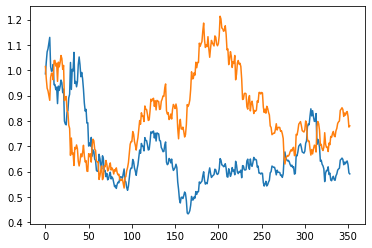

In [15]:
plt.plot(torch.cumprod(1 + strat, dim=0))
plt.plot(torch.cumprod(1 + r, dim=0))
plt.show()

Годовая доходность стратегии скользящих средних -31.74%
Годовая доходность стратегии buy and hold -16.47%


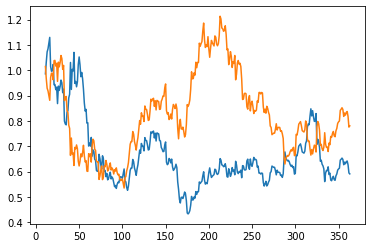

In [16]:
#визуализируем результаты
plt.plot(np.cumprod(1+data['strategy']))
plt.plot(np.cumprod(1+data['r']))
r_strat = np.prod(1+data['strategy'])**(256/len(data['strategy'])) - 1
r_bnh = np.prod(1+data['r'])**(256/len(data['r'])) - 1
print('Годовая доходность стратегии скользящих средних '+str(round(r_strat*100,2))+'%')
print('Годовая доходность стратегии buy and hold '+str(round(r_bnh*100,2))+'%')

In [17]:
#функции для подсчета доходностей
def profitability_bnh(prices: torch.Tensor):
    """
      Доходность стратегии Buy and hold за весь период
    """
    r = prices[1:]/prices[:-1] - 1
    return torch.prod(1 + r, dim=0) - 1

def profability_mooving_average(prices: torch.Tensor, short: int, long: int):
    """
      Доходность скользящих средних за весь период
    """
    r = prices[1:]/prices[:-1] - 1
    short_moving = moving_average(prices, short)[long-short:-1]
    long_moving = moving_average(prices, long)[:-1]
    r = r[long-1:]
    strat = r * (short_moving > long_moving) - r * (short_moving < long_moving)
    return torch.prod(1 + strat, dim=0) - 1

In [18]:
profitability_bnh(prices), profability_mooving_average(prices, 3, 20)

(tensor(-0.2512), tensor(-0.1492))

In [33]:
def sgd_step(x_0:int, y_0:int):
    a = profability_mooving_average(prices, x_0,y_0)
    b = profability_mooving_average(prices, x_0 + 1,y_0)
    c = profability_mooving_average(prices, x_0 - 1,y_0)
    d = profability_mooving_average(prices, x_0,y_0 + 1)
    e = profability_mooving_average(prices, x_0,y_0 - 1)
    if a == max(a,b,c,d,e):
        return x_0,y_0
    elif b == max(a,b,c,d,e):
        return (x_0 + 1,y_0)
    elif c == max(a,b,c,d,e):
        return (x_0 - 1,y_0)
    elif d == max(a,b,c,d,e):
        return (x_0, y_0 + 1)
    else:
        return (x_0, y_0 - 1)

def sgd(x_0:int, y_0:int):
    (x,y) = sgd_step(x_0,y_0)
    while (x, y) != (x_0, y_0):
        x_0, y_0 = x, y
        (x, y) = sgd_step(x_0, y_0)
    return x_0, y_0
    
    

In [37]:
x, y = sgd(3,22)
print(x, y)
print(profability_mooving_average(prices, x, y))

4 21
tensor(0.0470)


In [40]:
import random

In [96]:
def monte(n:int):
  l=[]
  x=np.zeros(n, dtype=int)
  y=np.zeros(n, dtype=int)
  x_0=np.zeros(n, dtype=int)
  y_0=np.zeros(n, dtype=int)
  for i in range(n):
    x[i] = random.randint(2,20)
    y[i] = random.randint(x[i] + 1,50)
    #print(x[i], y[i])
    x_0[i],y_0[i] = sgd(x[i],y[i])
    #print(int(x_0[i]), int(y_0[i]))
    l.append(float(profability_mooving_average(prices, int(x_0[i]), int(y_0[i]))))
  maximize = max(l)
  idx = l.index(maximize)

  #print(l)
  return maximize, x_0[idx], y_0[idx]



In [106]:
print(monte(20))

(0.8335689306259155, 3, 37)
